In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit 
using Plots, LaTeXStrings
using DelimitedFiles, DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
function print_fit_values(fit, par0, par_names)
    println(@sprintf "RSS = %.5e (convergence: %s)" sum(abs2, fit.resid) fit.converged)
    for i in 1:length(par0)
        name = par_names[i]
        val = fit.param[i]
        CIl = confidence_interval(fit, 0.05)[i][1]
        CIr = confidence_interval(fit, 0.05)[i][2]
        p0 = par0[i]
        println(@sprintf "  %s = %.3e (CI=(%.3e, %.3e), initial=%.3e)" name val CIl CIr p0)
    end
end

print_fit_values (generic function with 1 method)

# Viral load data fitting

Human SARS-Cov2 data from

*To, K. K. W., Tsang, O. T. Y., Leung, W. S., Tam, A. R., Wu, T. C., Lung, D. C., Yip, C. C. Y., Cai, J. P., Chan, J. M. C., Chik, T. S. H., Lau, D. P. L., Choi, C. Y. C., Chen, L. L., Chan, W. M., Chan, K. H., Ip, J. D., Ng, A. C. K., Poon, R. W. S., Luo, C. T., … Yuen, K. Y. (2020). Temporal profiles of viral load in posterior oropharyngeal saliva samples and serum antibody responses during infection by SARS-CoV-2: an observational cohort study. The Lancet Infectious Diseases, 20(5), 565–574. https://doi.org/10.1016/S1473-3099(20)30196-1*


## Data set



In [80]:
data = readdlm("../../data/To2020/Figure_2_Viral_Load.csv", ',', Any, '\n', header=true)[1]
DataFrame(data)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,0,,,,,,,,,,,,,
2,1,5.21924,,,,,,,,,,,,
3,2,,,,,,,,8.42034,,,3.76403,,4.30903
4,3,4.77062,,,,,,,6.05675,,,,,
5,4,,,8.63656,,,,,6.21165,4.85564,6.04999,,,3.77379
6,5,,7.38193,,,6.6963,,,7.11621,6.68878,1,,,
7,6,1,7.35384,,,,,7.04338,1,,,,,
8,7,5.29376,,,,,,,4.7673,,,,,
9,8,1,,7.85297,8.4431,,,6.96152,5.14451,,,,,


In [111]:
ttdata = Float64.(data[:, 1])
temp = data[:, 2:end]
temp[temp .== ""] .= missing
vvdata = [mean(skipmissing(temp[i, :])) for i in 1:size(temp)[1]]
vvstd = [std(skipmissing(temp[i, :])) for i in 1:size(temp)[1]]
vvcount = [count(temp[i, :] .!== missing) for i in 1:size(temp)[1]];

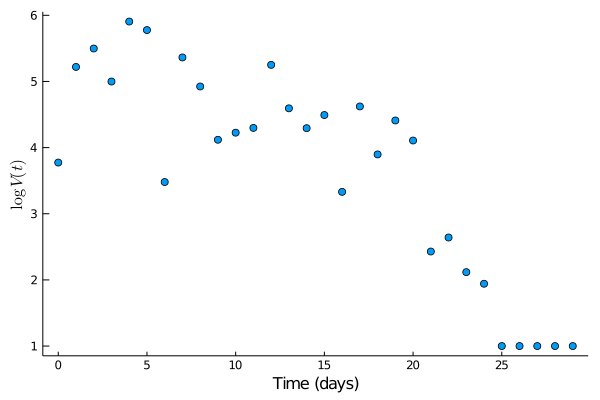

In [112]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

## Models

### Standard virus load function

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [78]:
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
v₁(t, a₁, a₂, logVmax) = 1. + (10^logVmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/(a₂ - a₁)))/2
v₂(t, a₂, α) = 1. - heaviside(t - a₂) + heaviside(t - a₂)*exp(-α*(t - a₂))
v₃(t, b₁, b₂, logVmin) = 1. - (1.0 - 10^logVmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/(b₂ - b₁)))/2
function VirusLoadFunction(t, p)
    a₁, a₂, b₁, b₂, α, logVmin, logVmax = p
    if a₁ > a₂ @warn "a₁ > a₂" end
    if a₂ > b₁ @warn "a₂ > b₁" end
    if b₁ > b₂ @warn "b₁ > b₂" end
    if logVmin > logVmax @warn "logVmin > logVmax" end
    log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
end
namesVLF = ["a₁", "a₂", "b₁", "b₂", "α", "logVmin", "logVmax"];
function VLFBounds(p)
    a₁, a₂, b₁, b₂, α, logVmin, logVmax = p
    a₁a₂, a₂b₁, b₁b₂ = (a₂-a₁)/2, (b₁-a₂)/2, (b₂-b₁)/2
    logVmid = (logVmax-logVmin)/2
    lb = [0, a₁+a₁a₂, a₂+a₂b₁, b₁+b₁b₂, 1e-2α, logVmin-logVmid, logVmax-logVmid]
    ub = [a₁+a₁a₂, a₂+a₂b₁, b₁+b₁b₂, b₁b₂+b₂, 1e+2α, logVmin+logVmid, logVmax+logVmid]
    lb, ub
end

VLFBounds (generic function with 1 method)

### Standard virus-target ODE Model


The standard viral kinetic model with varying clearance rate reads
$$
\begin{aligned}
\frac{dT}{dt} & = -\beta T V, \\
\frac{dI_1}{dt} & = \beta T V - k I_1, \\
\frac{dI_2}{dt} & = k I_1 - \frac{\delta I_2}{K + I_2}, \\
\frac{dV}{dt} & = p I_2 -c V.
\end{aligned}
$$

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


In [79]:
VirusTargetODE = @ode_def begin
    dT = -β*T*V
    dI₁ = β*T*V - k*I₁
    dI₂ = k*I₁ - δ*I₂/(K + I₂)
    dV = p*I₂ - c*V
end β k δ K p c;
u0 = [1e+7, 75.0, 0.0, 1e0]
tend = 35.
tspan = (0.0, tend)
function VirusTargetModel(t, p)
    pars = (β = p[1], k = p[2], δ = p[3], K = p[4], p = p[5], c = p[6])
    prob = ODEProblem(VirusTargetODE, u0, tspan, pars)
    sol = solve(prob, Tsit5(), dtmax=1e-2)
    log10.(sol(t)[4, :])
end
namesVTM = ["β", "k", "δ", "K", "p", "c"];

## Fitting models to data

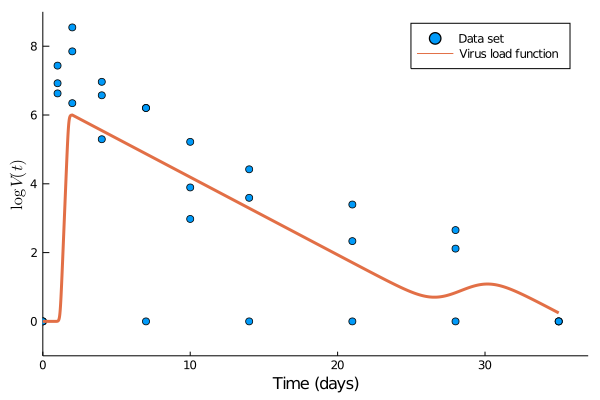

In [82]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmin, logVmax
par0 = [1.50, 2.00, 25.0, 35.0, 0.52, 1.70,   6.00]
tt = [range(0., tend, step=1e-2);]
pt = plot(ttdata, vvdata, seriestype=:scatter,
    label="Data set", grid=:off,
    xaxis = ("Time (days)", (0., 37.)),
    yaxis = (L"$\log\, V(t)$", (-1, 9)))
plot!(pt, tt, VirusLoadFunction(tt, par0), lw=3, label="Virus load function")
display(pt)

In [88]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmin, logVmax
par0 = [0.01, 5.80, 27.0, 30.0, 0.52, -4,    8.0]
lb, ub = VLFBounds(par0)
fitVLF = curve_fit(VirusLoadFunction, ttdata, vvdata, par0, lower=lb, upper=ub);

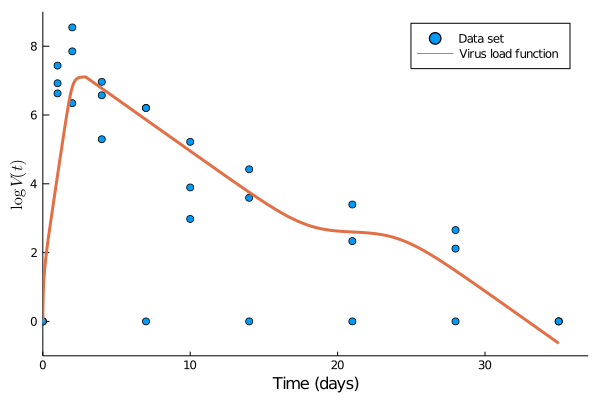

7-element Array{Float64,1}:
  1.0877255171854519
  2.905
 16.4
 31.5
  0.6989489118415272
  2.0
  7.107198386656149

In [89]:
pt = plot(ttdata, vvdata, seriestype=:scatter,
    label="Data set", grid=:off,
    xaxis=("Time (days)", (0., 37.)),
    yaxis=(L"$\log\, V(t)$", (-1, 9)))
plot!(pt, tt, VirusLoadFunction(tt, fitVLF.param), lw=3, label="Virus load function")
display(pt)
fitVLF.param

In [90]:
print_fit_values(fitVLF, par0, namesVLF)

RSS = 9.64902e+01 (convergence: false)
  a₁ = 1.088e+00 (CI=(-9.523e-02, 2.271e+00), initial=1.000e-02)
  a₂ = 2.905e+00 (CI=(-4.832e-01, 6.293e+00), initial=5.800e+00)
  b₁ = 1.640e+01 (CI=(-2.069e+02, 2.397e+02), initial=2.700e+01)
  b₂ = 3.150e+01 (CI=(-5.570e+02, 6.200e+02), initial=3.000e+01)
  α = 6.989e-01 (CI=(-7.294e-01, 2.127e+00), initial=5.200e-01)
  logVmin = 2.000e+00 (CI=(-1.587e+01, 1.987e+01), initial=-4.000e+00)
  logVmax = 7.107e+00 (CI=(4.831e+00, 9.383e+00), initial=8.000e+00)


In [120]:
#       β     , k     , δ     , K     , p     , c
par0 = [2.5e-4, 1.5e+0, 1.6e+6, 5.0e+4, 2.1e+0, 1.5e+1]
lb   = [0.0,    0.0,    0.0,    0.0,    0.0,    0.0]
ub   = [Inf,    Inf,    Inf,    Inf,    Inf,    Inf]
fitVTM = curve_fit(VirusTargetModel, ttdata, vvdata, par0, lower=lb, upper=ub);

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /home/shigoto/.julia/packages/DiffEqBase/zXRWE/src/integrator_interface.jl:329


DomainError: DomainError with -3.3940875689604816e9:
NaN result for non-NaN input.

In [121]:
print_fit_values(fitVTM, par0, namesVTM)

UndefVarError: UndefVarError: fitVTM not defined

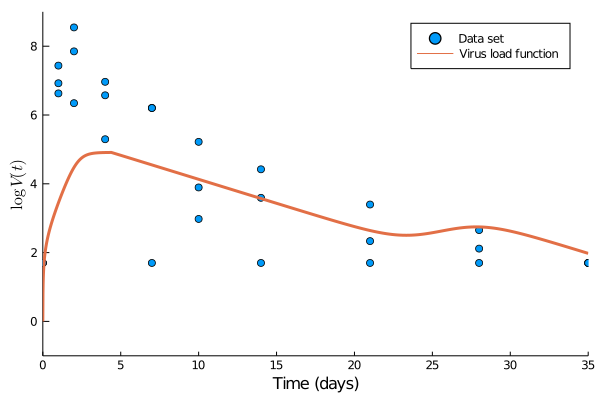

In [133]:
tt = [range(0., tend, step=1e-2);]
pt = plot(ttdata, vvdata, seriestype=:scatter,
    label="Data set", grid=:off,
    xaxis = ("Time (days)", (0., 35.)),
    yaxis = (L"$\log\, V(t)$", (-1, 9)))
plot!(pt, tt, VirusLoadFunction(tt, fitVLF.param), lw=3, label="Virus load function")
# plot!(pt, tt, VirusTargetModel(tt, fitVTM.param), lw=3, label="Virus-target model")
#savefig(figdir*"Smith2018DataFit.png")
#savefig(figdir*"Smith2018DataFit.pdf")
display(pt)